# Point to point Zero Order Hold

In this tutorial we show the use of the {class}`pykep.trajopt.zoh_point2point` to find a low-thrust trajectory connecting two fixed points in space. 
Since the points are considered fixed this effort has mainly an academic value, but it is infomrative in the study of the numerical properties of an optimization pipeline based on a ZOH direct transcription.

The decision vector in this class compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems) is:

$$
\mathbf x = [m_f, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [ ]:
## Copyright 2023, 2024 Dario Izzo (dario.izzo@gmail.com), Francesco Biscani
## (bluescarni@gmail.com)##
## This file is part of the kep3 library.##
## This Source Code Form is subject to the terms of the Mozilla
## Public License v. 2.0. If a copy of the MPL was not distributed
## with this file, You can obtain one at http://mozilla.org/MPL/2.0/.

import numpy as _np
import pykep as _pk


class zoh_point2point:
    """Represents the optimal low-thrust transfer between two fixed points using `pykep`'s Zero Order Hold (direct) method.

    This problem works internally using the :class:`~pykep.leg.sims_flanagan` and manipulates its transfer time T,
    final mass mf and the controls as to link two fixed points in space with a low-thrust trajectory.

    It can be used to better profile and understand performances of optimizers on this type of direct approach, but has a limited use
    in the design of interplanetary trajectories as per the fixed point limitation.

    The decision vector is::

        x = [mf] + controls + tof

    where controls is a vector of control parameters :math:`[T, i_x, i_y, i_z] \\times n_\\text{seg}` representing magnitude and direction
    of the thrust applied in each segment.
    """

    def __init__(
        self, states, statef, ms, max_thrust, tof_bounds, mf_bounds, nseg, cut, tas
    ):
        """
        Initializes the zoh_point2point instance with given parameters.

        Args:
            *states* (:class:`list`): Initial state (only the first 6 states, i.e. no mass). Units as expected by the numerical integrator.

            *statef* (:class:`list`): Final state (only the first 6 states, i.e. no mass). Units as expected by the numerical integrator.

            *ms* (:class:`float`): Initial mass. Units as expected by the numerical integrator.

            *max_thrust* (:class:`float`): Maximum thrust. Units as expected by the numerical integrator.

            *tof_bounds* (:class:`list`): Bounds for time of flight. Units as expected by the numerical integrator.

            *mf_bounds* (:class:`list`): Bounds for final mass. Units as expected by the numerical integrator.

            *nseg* (:class:`int`): Number of segments for the trajectory. Defaults to 10.

            *cut* (:class:`float`): Cut parameter for the :class:`~pykep.leg.sims_flanagan`. Defaults to 0.6.

            *tas* (:class:`tuple`): `(ta, ta_var)` Taylor-adaptive integrators

                - `ta`: Nominal dynamics (state dim 7, pars ≥ 4)

                - `ta_var`: Variational dynamics (state dim 84, same pars). When None, no gradients will be used.

        """
        # We define some additional datamembers useful later-on
        self.nseg = nseg
        self.tof_bounds = tof_bounds
        self.mf_bounds = mf_bounds
        self.max_thrust = max_thrust
        self.with_gradient = tas[1] is None

        # We build and store a ZOH leg as data member.
        # We will change controls, tgrid and mf as those are encoded in the decision vector,
        # but to construct we need some values to construct the first instance...
        tgrid = _np.linspace(
            0, (self.tof_bounds[0] + self.tof_bounds[1]) / 2, self.nseg + 1
        )
        controls = _np.random.uniform(-1, 1, (4 * nseg,))
        controls[0::4] = _np.abs(controls[0::4])  # force will be in [0, 1]
        controls[0::4] *= self.max_thrust  # force will be in [0, max_thrust]
        self.leg = _pk.leg.zoh(states + [ms], controls, statef + [ms], tgrid, cut, tas)

    def _set_leg_from_x(self, x):
        # Here is where the decision vector gets decoded into the leg tgrid, mf and controls
        # Lets do this case: x = [mf] + controls + tof
        self.leg.state0[-1] = x[0]
        self.leg.controls = x[1 : 1 + 4 * self.nseg]
        self.leg.controls[0::4] *= self.max_thrust
        # Since we only have tof in the decision vector we assume a uniform epoch grid
        self.leg.tgrid = _np.linspace(0, x[1 + 4 * self.nseg], self.nseg + 1)

    def get_bounds(self):
        lb = (
            [self.mf_bounds[0]]
            + [0, -1.0, -1.0, -1.0] * self.nseg
            + [self.tof_bounds[0]]
        )
        ub = (
            [self.mf_bounds[1]]
            + [1.0, 1.0, 1.0, 1.0] * self.nseg
            + [self.tof_bounds[1]]
        )
        return (lb, ub)

    def fitness(self, x):
        # We set the leg using data in the decision vector
        self._set_leg_from_x(x)

        # We optimize for maximum final mass (minimum propellent)
        obj = -x[0]

        # We compute the equality constraints
        ceq = self.leg.compute_mismatch_constraints()
        ceq += self.leg.compute_throttle_constraints()
        retval = _np.array([obj] + ceq)

        return retval

    # If the variational integator is also passed in construction (i.e. its not None)
    # gradient should be provided (pagmo UDP interface used this method to know)
    def has_gradient(self):
        return self.with_gradient

    # Only equality contraints. Mismatches and the |i_u| = 1.
    def get_nec(self):
        return 7 + self.nseg

In [12]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

First we define some problem data

In [13]:
# Physical parameters
max_thrust = 0.12 # N
veff = 3000 * pk.G0 # m/s
mu = pk.MU_SUN # m^3/s^2

# Initial state (Cartesian)
ms = 1500.0 # kg
rs = np.array([1.2, 0.0, -0.01]) * pk.AU
vs = np.array([0.01, 1, -0.01]) * pk.EARTH_VELOCITY

# Final state (Cartesian)
rf = np.array([1, 0.0, -0.0]) * pk.AU
vf = np.array([0.01, 1.1, -0.0]) * pk.EARTH_VELOCITY

Then we instantiate the ZOH Taylor integrators, these need to be set in nondimensional units so we define those too!

In [16]:
# Non dimensional units
L = pk.AU
MU = mu # (central body mu must be 1 in these units as a requirement of the ZOH integrator used)
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = ms
F = MASS*ACC

# Non dimensional problem data
ms_nd = ms / MASS
rs_nd = [it/L for it in rs]
vs_nd = [it/V for it in vs]
rf_nd = [it/L for it in rf]
vf_nd = [it/V for it in vf]

# Instantiating the ZOH integrators
# Tolerances used in the numerical integration
# Low tolerances result in higher speed (the needed tolerance depends on the orbital regime)
tol=1e-10
tol_var = 1e-6

# We instantiate ZOH Taylor integrators for Keplerian dynamics.
ta = pk.ta.get_zoh_kep(tol)
ta_var = pk.ta.get_zoh_kep_var(tol_var)

# We set the Taylor integrator parameters
veff_nd = veff / V
ta.pars[4] = 1. / veff_nd
ta_var.pars[4] = 1. / veff_nd

In [42]:
pop.champion_x

array([  2.49827553e-01,   5.44602770e-03,   5.12399878e-02,
        -8.09358255e-01,   3.38631981e-01,   5.10974576e-03,
        -2.52827096e-01,   9.90783316e-01,   5.76413730e-01,
         1.59462672e-03,  -1.03144535e-01,  -6.97330571e-01,
         3.88247326e-01,   3.75922219e-03,  -5.09388722e-01,
        -1.91754933e-01,  -3.71033425e-01,   8.16162087e+00])

In [ ]:
# Throttles and tof
nseg = 4
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 2 * np.pi * np.sqrt(pk.AU**3 / pk.MU_SUN) / 4

udp = zoh_point2point(
    states=rs_nd + vs_nd,
    statef=rf_nd + vf_nd,
    ms=ms_nd,
    max_thrust=max_thrust / F,
    tof_bounds=[200 * pk.DAY2SEC / TIME, 500 * pk.DAY2SEC / TIME],
    mf_bounds=[0.2, 1],
    nseg=4,
    cut=0.6,
    tas=[ta, None],
)

In [36]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=True)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)

# uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

array([-0.24982755,  0.19159873,  1.15391974,  0.051909  , -0.6298315 ,
        0.14882856,  0.03150303, -0.78303698, -0.22764206,  0.37782591,
       -0.35235529, -0.56608737])

In [37]:
prob = pg.problem(udp)
prob.c_tol = 1e-6
prob = pg.problem(udp)
prob.c_tol = 1e-6
pop = pg.population(prob, 1)

In [39]:
pop_g = algo.evolve(pop)
print(prob.feasibility_f(pop.champion_f))

   SNOPT  C interface  2.0.0   
 S N O P T  7.2-4    (Jun 2006)
 
 SNMEMA EXIT 100 -- finished successfully
 SNMEMA INFO 104 -- memory requirements estimated
 

 Nonlinear constraints      11     Linear constraints       0
 Nonlinear variables        18     Linear variables         0
 Jacobian  variables        18     Objective variables     18
 Total constraints          11     Total variables         18
 

 
 The user has defined       0   out of     216   first  derivatives
 

 Major Minors     Step   nCon Feasible  Optimal  MeritFunction    nS Penalty
     0     21               1  2.7E-01  5.0E-01  5.5786000E+04                 r i
     1      8  5.3E-01      2  1.9E-01  2.7E-01  3.3854507E+04     2         n rli
     2     17  7.8E-01      4  1.6E-01  6.4E-02  1.9488026E+04     3         sm li
     3      5  1.0E+00      6  2.3E-01  3.4E-02  1.4821956E+04     3          m  i
     4     14  1.0E+00      8  3.4E-01  6.7E-03  1.2611742E+04     3          m  i
     5      1  1.2E-02 

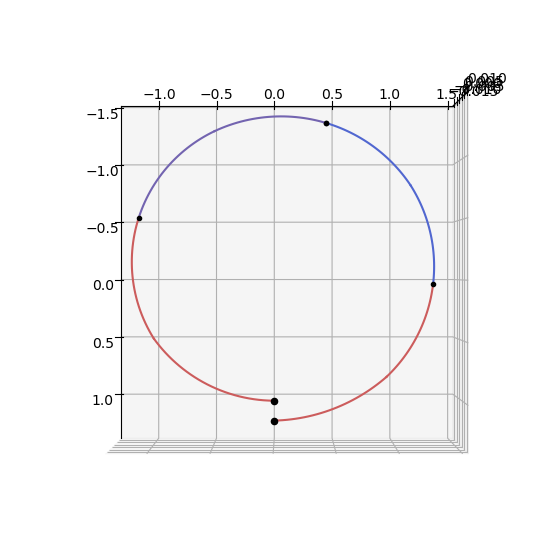

In [8]:
ax = udp_nog.plot(pop_g.get_x()[0], show_gridpoints=True)
ax.view_init(90, 0)

In [9]:
from tqdm import tqdm

cpu_nog = []
cpu_g = []

fail_g = 0
fail_nog = 0

for i in tqdm(range(2000)):
    pop_nog = pg.population(prob_nog, 1)

    pop_g = pg.population(prob_g)
    pop_g.push_back(pop_nog.get_x()[0])

    start = time.time()
    pop_g = algo.evolve(pop_g)
    end = time.time()
    cpu_g.append(end - start)
    if not prob_g.feasibility_f(pop_g.champion_f):
        fail_g += 1

    start = time.time()
    pop_nog = algo.evolve(pop_nog)
    end = time.time()
    cpu_nog.append(end - start)
    if not prob_nog.feasibility_f(pop_nog.champion_f):
        fail_nog += 1

print(f"Gradient: {np.median(cpu_g):.4e}s")
print(f"No Gradient: {np.median(cpu_nog):.4e}s")

print(f"\nGradient (n.fails): {fail_g}")
print(f"No Gradient (n.fails): {fail_nog}")

100%|██████████| 2000/2000 [1:57:55<00:00,  3.54s/it]    

Gradient: 2.7463e-01s
No Gradient: 2.7796e-01s

Gradient (n.fails): 192
No Gradient (n.fails): 189


Text(0, 0.5, 'N. occurrences')

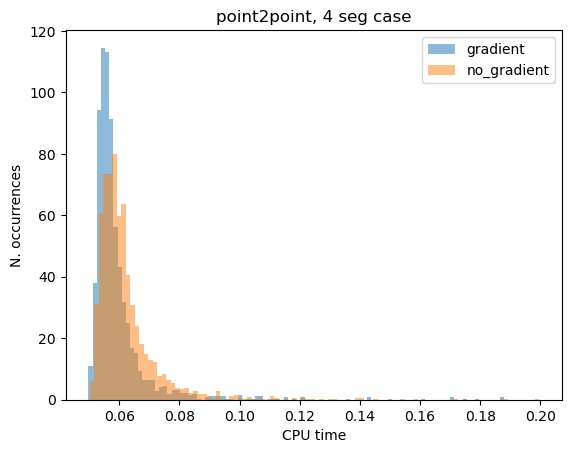

In [7]:
cpu_g = np.array(cpu_g)
cpu_nog = np.array(cpu_nog)
plt.hist(cpu_g[cpu_g < 0.2], bins=100, label="gradient", density=True, alpha=0.5)
plt.hist(cpu_nog[cpu_nog < 0.2], bins=100, label="no_gradient", density=True, alpha=0.5)
# plt.xlim([0,0.15])
plt.legend()
plt.title("point2point, 4 seg case")
plt.xlabel("CPU time")
plt.ylabel("N. occurrences")

In [8]:
udp_g.leg.tof=1232.
udp_g.leg

Number of segments: 2
Number of fwd segments: 1
Number of bck segments: 1
Maximum thrust: 0.22
Central body gravitational parameter: 1.32712440018e+20
Specific impulse: 3000

Time of flight: 1232
Initial mass: 1000
Final mass: 1
State at departure: [[179517444840, 0, -1495978707], [297.8469183169681, 29784.691831696804, -297.8469183169681]]
State at arrival: [[149597870700, 0, -0], [297.8469183169681, 32763.161014866488, -0]]
Throttles values: [0, 0, 0, 0, 0, 0]

Mismatch constraints: [29919941431.26764, 38529477.27626525, -1496162174.1910896, -6.189427009557562, -2978.469066381742, -297.82577960576987, 999]
Throttle constraints: [-1, -1]
